In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave
import pandas as pd
import csv
import random
import math
import pickle

from __future__ import print_function
import os
from functools import partial
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### Load the Dataset

Reserve 1/3 for validation.

(6666, 2)
(3334, 2)


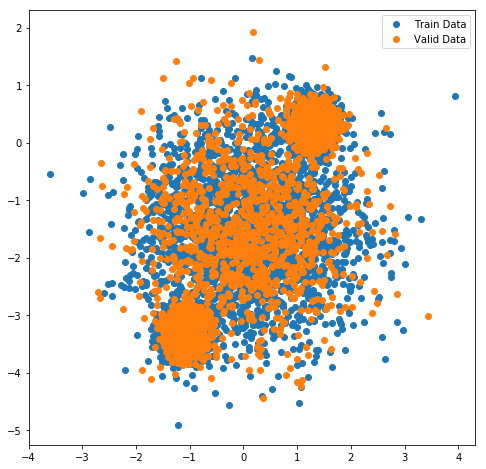

In [6]:
# load dataset
data = np.load('data2D.npy')
np.random.shuffle(data)

train_data = data[:int(data.shape[0] * 2 / 3)]
valid_data = data[int(data.shape[0] * 2 / 3):]

print(train_data.shape)
print(valid_data.shape)

plt.figure(figsize=(8, 8))
plt.scatter(train_data[:,0], train_data[:,1], label='Train Data')
plt.scatter(valid_data[:,0], valid_data[:,1], label='Valid Data')
plt.legend()
plt.savefig('1.1.4-Dist.png')
plt.show()

### Build the Mixture of Gaussians Model

In [7]:
def mog_model(K):
    # hyperparameters
    η = 0.001
    β1 = 0.9
    β2 = 0.99
    ϵ = 0.00001
    NUM_CENTROIDS = K
    NUM_EPOCHS = 750
    PRINT_FREQ = 0.1

    # variables
    train_loss_profile = []
    valid_loss_profile = []
    epoch_profile = []

    # placeholders
    x = tf.placeholder(shape=[None,2], dtype=tf.float32)

    # variables
    μ = tf.Variable(tf.random_normal([NUM_CENTROIDS, 2]), name='centroid_ev')
    ψ = tf.Variable(tf.random_normal([NUM_CENTROIDS, 1]), name='centroid_mag_unconstrained')
    ϕ = tf.Variable(tf.random_normal([NUM_CENTROIDS, 1]), name='centroid_var_unconstrained')
    
    # contstrained variables
    π = tf.exp(logsoftmax(ψ))
    σ2 = tf.exp(ϕ)
    
    # loss
    x_exp = tf.expand_dims(x, -1)
    μ_exp = tf.expand_dims(μ, -1)
    
    l2 = tf.reduce_sum((x_exp - tf.transpose(μ_exp, [2,1,0]))**2, axis=1)
    
    log_exp = l2 / (2 * tf.transpose(σ2))
    log_coeff = tf.transpose(tf.log(π / tf.sqrt(2 * np.pi * σ2)))
    
    exp_prob_x = log_coeff - log_exp
    loss = -tf.reduce_sum(reduce_logsumexp(exp_prob_x))
    pred_val, pred_index = tf.nn.top_k(tf.exp(exp_prob_x))

    # optimizer
    optimizer = tf.train.AdamOptimizer(η, beta1=β1, beta2=β2, epsilon=ϵ)
    train = optimizer.minimize(loss=loss)

    # init
    sess.run(tf.global_variables_initializer())

    # train
    train_loss_profile.append(sess.run(loss, feed_dict={x:train_data}))
    valid_loss_profile.append(sess.run(loss, feed_dict={x:valid_data}))
    epoch_profile.append(0)
    for epoch in range(NUM_EPOCHS + 1):
        sess.run(train, feed_dict={x:train_data})

        train_loss_profile.append(sess.run(loss, feed_dict={x:train_data}))
        valid_loss_profile.append(sess.run(loss, feed_dict={x:valid_data}))
        epoch_profile.append(epoch)

    # obtain final model values
    pred_cent_index = sess.run(pred_index, feed_dict={x:data})
    pred_μ = sess.run(μ)

    # plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_profile, train_loss_profile, label='Train Loss')
    plt.plot(epoch_profile, valid_loss_profile, label='Valid Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch Number')
    plt.legend()
    plt.savefig('1.1.4-'+str(NUM_CENTROIDS)+'-Loss.png')
    plt.show()

    # obtain percent allocated to each centroid
    unique, counts = np.unique(pred_cent_index, return_counts=True)
    percent_each = dict(zip(unique, counts / data.shape[0]))

    print('Final Loss:', train_loss_profile[-1], valid_loss_profile[-1])
    print('Final Percent Each:', percent_each)
    
    return train_loss_profile[-1], valid_loss_profile[-1], percent_each

### Run the MoG Model with Different numbers of Centroids

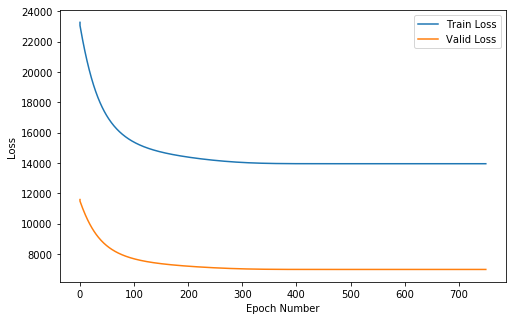

c:\users\sev\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


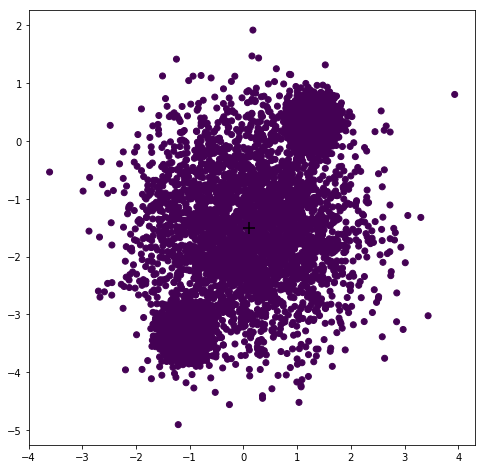

Final Loss: 13949.4 6974.4
Final Percent Each: {0: 1.0}


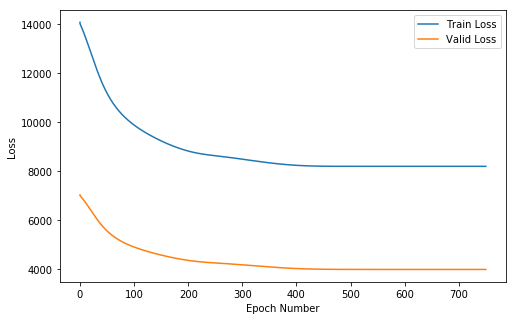

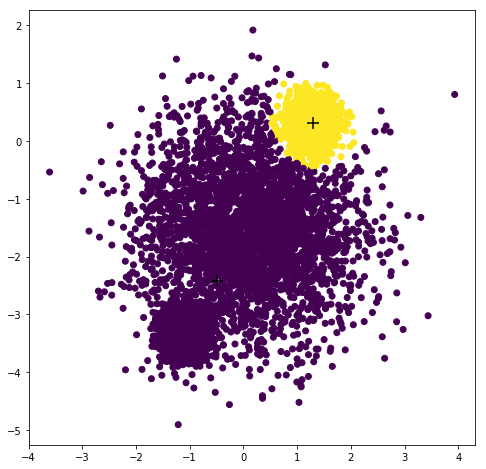

Final Loss: 8201.18 3990.53
Final Percent Each: {0: 0.65649999999999997, 1: 0.34350000000000003}


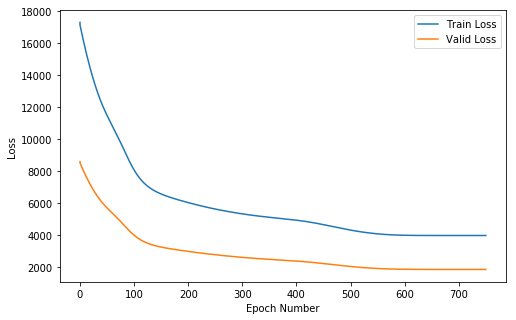

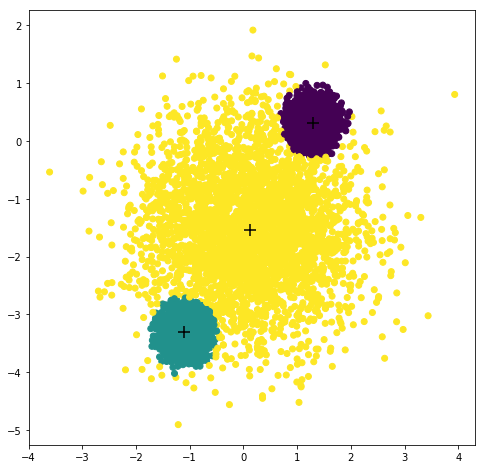

Final Loss: 3963.05 1841.61
Final Percent Each: {0: 0.33860000000000001, 1: 0.33789999999999998, 2: 0.32350000000000001}


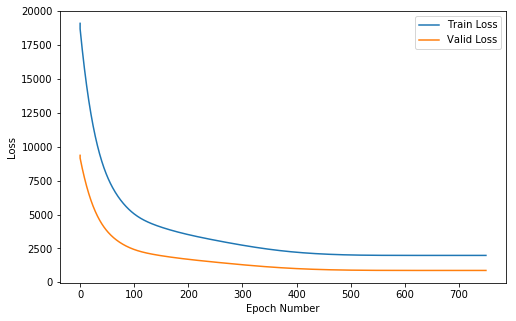

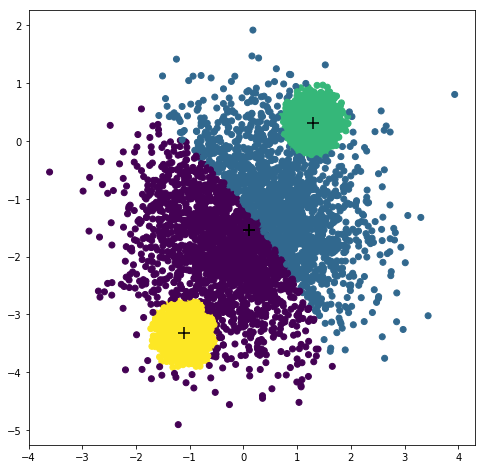

Final Loss: 1990.25 881.326
Final Percent Each: {0: 0.1792, 1: 0.14699999999999999, 2: 0.33760000000000001, 3: 0.3362}


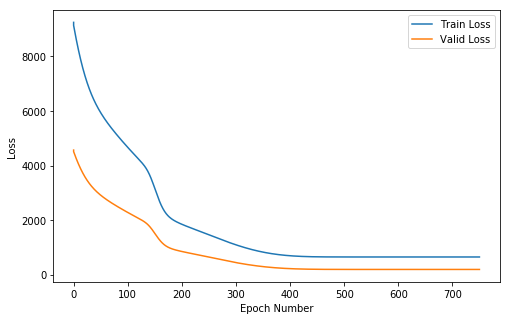

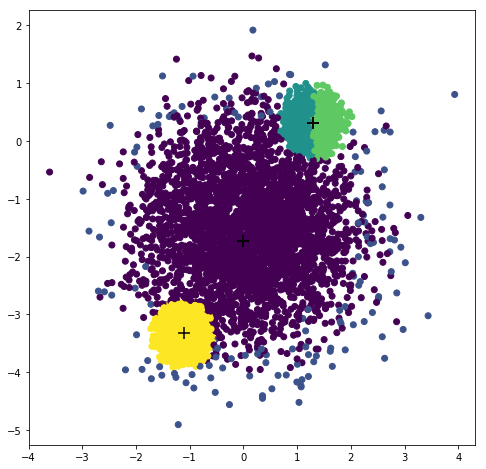

Final Loss: 647.952 191.078
Final Percent Each: {0: 0.31169999999999998, 1: 0.015100000000000001, 2: 0.16880000000000001, 3: 0.17100000000000001, 4: 0.33339999999999997}


In [10]:
K_values = [1,2,3,4,5]
results = []

for K in K_values:
    results.append(mog_model(K))

### Obtain the Optimal Number of Centroids Using the Elbow Curve Method

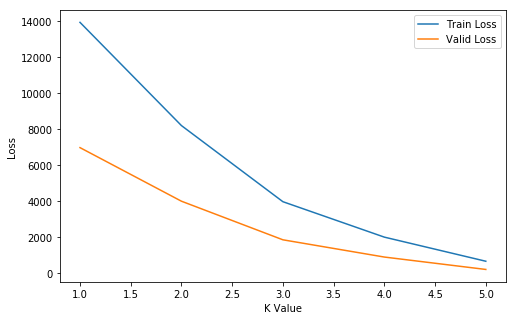

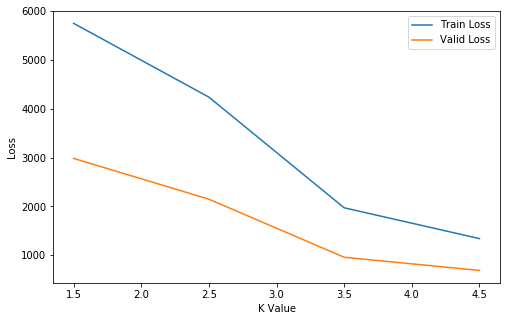

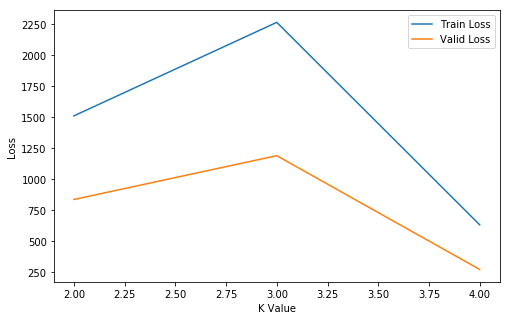

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(1, 5, 5), [l[0] for l in results], label='Train Loss')
plt.plot(np.linspace(1, 5, 5), [l[1] for l in results], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('K Value')
plt.legend()
plt.savefig('1.1.4-Elbow.png')
plt.show()

delta_valid = [abs(results[i][1] - results[i - 1][1]) for i in range(1, 5)]
delta_train = [abs(results[i][0] - results[i - 1][0]) for i in range(1, 5)]

# delta
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(1.5, 4.5, 4), delta_train, label='Train Loss')
plt.plot(np.linspace(1.5, 4.5, 4), delta_valid, label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('K Value')
plt.legend()
plt.savefig('1.1.4-Elbow-delta.png')
plt.show()

curv_valid = [abs(delta_valid[i] - delta_valid[i - 1]) for i in range(1, 4)]
curv_train = [abs(delta_train[i] - delta_train[i - 1]) for i in range(1, 4)]

# delta
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(2, 4, 3), curv_train, label='Train Loss')
plt.plot(np.linspace(2, 4, 3), curv_valid, label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('K Value')
plt.legend()
plt.savefig('1.1.4-Elbow-curv.png')
plt.show()

As we can see, the MoG model yields us 3 centroids as the optimal number. Comparitively, our K-Means model yielded us a value of 2 centroids for the optimal number (pasted below for comparison)

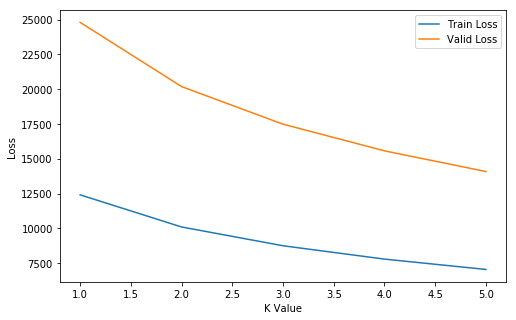

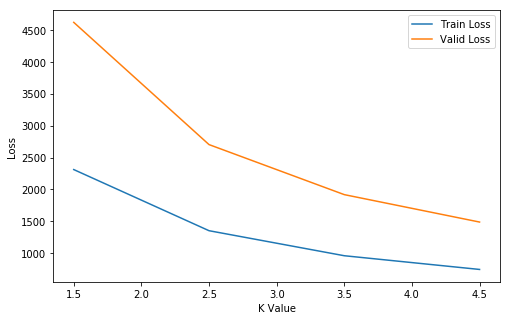

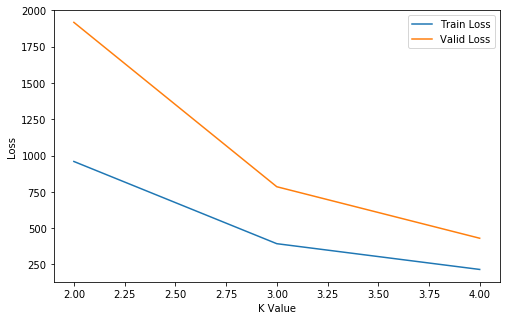

In [23]:
results = pickle.load( open( "save-small.p", "rb" ), encoding='latin1')
name = 'mog-small'

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(1, 5, 5), [l[0] for l in results], label='Train Loss')
plt.plot(np.linspace(1, 5, 5), [l[1] for l in results], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('K Value')
plt.legend()
plt.savefig(name+'-Elbow.png')
plt.show()

delta_valid = [abs(results[i][1] - results[i - 1][1]) for i in range(1, 5)]
delta_train = [abs(results[i][0] - results[i - 1][0]) for i in range(1, 5)]

# delta
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(1.5, 4.5, 4), delta_train, label='Train Loss')
plt.plot(np.linspace(1.5, 4.5, 4), delta_valid, label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('K Value')
plt.legend()
plt.savefig(name+'-Elbow-delta.png')
plt.show()

curv_valid = [abs(delta_valid[i] - delta_valid[i - 1]) for i in range(1, 4)]
curv_train = [abs(delta_train[i] - delta_train[i - 1]) for i in range(1, 4)]

# delta
plt.figure(figsize=(8, 5))
plt.plot(np.linspace(2, 4, 3), curv_train, label='Train Loss')
plt.plot(np.linspace(2, 4, 3), curv_valid, label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('K Value')
plt.legend()
plt.savefig(name+'-Elbow-curv.png')
plt.show()